In [2]:
import os
import json
import uuid
import pandas as pd
import torch
import torchaudio
from torchvision.models import resnet18
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd
from torchsummary import summary

2024-07-03 13:57:06.224644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 13:57:07.261513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def determine_is_stridor(path):
    """
    Determine if the path should be marked as stridor based on the parent folder.
    """
    for part in path.split(os.sep):
        if part.upper() in ["CONTROL", "CONTROLS"]:
            return False
    return True

def generate_recording_objects(root_path, output_json):
    recordings = []

    # Traverse the directory structure
    for root, dirs, files in os.walk(root_path):
        # Check if there are wav files in the current directory
        wav_files = [file for file in files if file.endswith('.wav')]
        if wav_files:
            # Get the parent folder name
            parent_folder = os.path.basename(root)
            # Determine the isStridor value
            is_stridor = determine_is_stridor(root)
            
            for wav_file in wav_files:
                # Generate a unique ID for each player-session-recording combination
                uid = str(uuid.uuid4())
                # Extract the recording label (base name without extension)
                recording_label = os.path.splitext(wav_file)[0]
                # Create the entry for the current recording
                entry = {
                    "uid": uid,
                    "name": parent_folder,
                    "recording": os.path.join(root, wav_file),  # Include the full path
                    "recording_label": recording_label,
                    "isStridor": is_stridor
                }
                recordings.append(entry)
                
    return recordings

In [4]:
def filter_recordings_by_label(data, label_prefix):
    """
    Filter recordings to only include those with recording_label starting with the specified prefix.
    Exclude specific labels when the prefix is 'FIMO'.
    """
    exclude_labels = {"FIMO": ["FIMOcricoid", "FIMOthyroid", "FIMOC", "FIMOT"]}

    filtered_data = []
    for recording in data:
        if recording['recording_label'].startswith(label_prefix):
            if label_prefix == "FIMO" and recording['recording_label'] in exclude_labels["FIMO"]:
                continue
            filtered_data.append(recording)

    return filtered_data

In [5]:
# Usage
root_path = './stridor/Data files'  # Replace with the actual path to your folders
output_json = 'output_individual.json'  # Replace with the desired output JSON file name
data = generate_recording_objects(root_path, output_json)

print(f"rcordings: {data}")

rcordings: [{'uid': '70478ba8-70d9-4fd1-a707-c3e80f35ca82', 'name': 'Patient 1', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 1/FEMCcricoid.wav', 'recording_label': 'FEMCcricoid', 'isStridor': True}, {'uid': 'a262dc6e-bcbf-4024-aea3-d999c18c99ba', 'name': 'Patient 1', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 1/FEMOcricoid.wav', 'recording_label': 'FEMOcricoid', 'isStridor': True}, {'uid': '0051b8f2-cdec-4a83-abd4-c83478f68db6', 'name': 'Patient 1', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 1/FEMOthyroid.wav', 'recording_label': 'FEMOthyroid', 'isStridor': True}, {'uid': '8eec6a26-8c5e-46c4-a2f1-c4541b00e352', 'name': 'Patient 1', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 1/FIMCthyroid.wav', 'recording_label': 'FIMCthyroid', 'isStridor': True}, {'uid': 'bf255e36-865d-4bb8-abc0-a4d5d6adad2c', 'nam

In [6]:
# Filter the data to only include recordings with recording_label starting with "FIMO"
filtered_data = filter_recordings_by_label(data, "FIMO")

print(f"filtered recordings: {filtered_data}")

filtered recordings: [{'uid': '55b1af32-ee70-4235-ba4e-8ae7b9ca62c7', 'name': 'Patient 2', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 2/FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': '755a76bf-6b2e-424d-8a35-54e82e82abbf', 'name': 'Patient 3', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 3/FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': 'a0f17491-2a0b-41d6-bdd8-82154b5c989d', 'name': 'Patient 4', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 4/FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': '50e2275f-67e8-40c2-9e76-ee2e39189558', 'name': 'Patient 6', 'recording': './stridor/Data files/OLD methods/INITIAL (Avid, mostly asynchronous)/Patient 6/FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': '4e2ef129-a6a0-4e85-920b-2396ceda0e2a', 'n

In [7]:
df = pd.DataFrame(data)

print(f"df: {df}")

df:                                       uid        name  \
0    70478ba8-70d9-4fd1-a707-c3e80f35ca82   Patient 1   
1    a262dc6e-bcbf-4024-aea3-d999c18c99ba   Patient 1   
2    0051b8f2-cdec-4a83-abd4-c83478f68db6   Patient 1   
3    8eec6a26-8c5e-46c4-a2f1-c4541b00e352   Patient 1   
4    bf255e36-865d-4bb8-abc0-a4d5d6adad2c   Patient 1   
..                                    ...         ...   
722  edaaa6d2-020a-4a2d-b023-c78e2f35d654  Patient 42   
723  cbf10847-5845-43ab-9825-f51336bd2cfe  Patient 42   
724  1e37ec6e-b2bd-4613-84f0-ec6ffed97900  Patient 42   
725  c1f00bd5-0501-416a-8dc1-3c6d97e5ba42  Patient 42   
726  53e4d737-36c3-41fd-99f8-0682fb301a6c  Patient 42   

                                             recording recording_label  \
0    ./stridor/Data files/OLD methods/INITIAL (Avid...     FEMCcricoid   
1    ./stridor/Data files/OLD methods/INITIAL (Avid...     FEMOcricoid   
2    ./stridor/Data files/OLD methods/INITIAL (Avid...     FEMOthyroid   
3    ./stridor/

In [10]:
class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, segment_size=3):
        self.dataframe = dataframe
        self.segment_size = segment_size
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording', 'recording_label', 'isStridor']
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.labels = dataframe['isStridor'].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        recording_label = self.recording_labels[idx]

        try:
            audio = Audio.from_file(self.audio_files[idx])
            audio = audio.to_16khz()
            # get middle K seconds if audio is too long, pad with zeros if it is too short
            if audio.signal.size(0) > self.segment_size*16000:
                d = (audio.signal.size(0)-self.segment_size*16000)//2
                audio.signal = audio.signal[d:d+self.segment_size*16000]
            else:
                audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)
                
            win_length = 30
            hop_length = 10
            nfft = 512
            features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
            features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10))).T

            
            # I add this to reshape the image
            features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

        except Exception as e:
            print(f"Error loading {audio_file}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # Convert the label to a tensor
        label = torch.tensor(label, dtype=torch.float32)

        return {'uid': uid, 'signal': features_specgram, 'isStridor': label, 'recording_label': recording_label}

dataset: <__main__.MySpecgramDataset object at 0x7fe4790007c0>
['RegiPad', 'RPAvid', 'FIMOiPad', 'RPAvid', 'RMCavid', 'FIMOthyroid', 'FIMO12inch-flat', 'FEMOavid'] tensor([0., 0., 0., 1., 1., 1., 1., 0.])


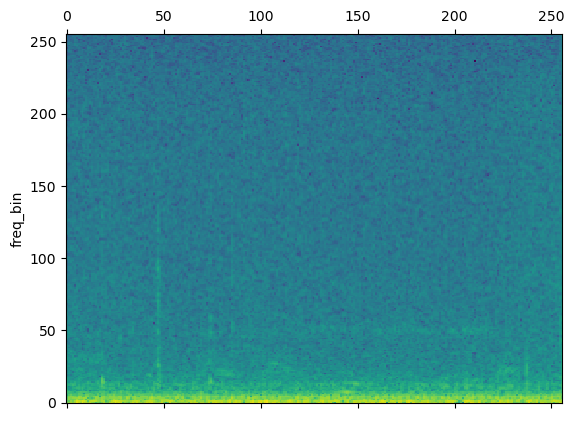

In [11]:
dataset = MySpecgramDataset(df)
print(f"dataset: {dataset}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    print(batch['recording_label'], batch['isStridor'])
    plot_spectrogram(batch['signal'][0])
    break

In [12]:
import torch
import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram):
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title("Spectrogram")
    plt.ylabel("Frequency bins")
    plt.xlabel("Time")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Initialize an empty list to collect the batches
all_batches = []

# Define the desired shape after padding
desired_shape = (8, 256, 256)

# Iterate through the data loader
for i, batch in enumerate(train_dataloader):
    if i >= 19:
        break
    
    signal = batch['signal']
    
    # Check if the batch has the expected number of samples
    if signal.shape[0] != desired_shape[0]:
        print(f"Skipping batch {i} because it has {signal.shape[0]} samples but expected {desired_shape[0]}")
        continue
    
    # Pad or reshape each signal to match desired_shape
    if signal.shape != desired_shape:
        # Assuming padding is necessary
        padded_signal = torch.nn.functional.pad(signal, (0, 10))
    else:
        padded_signal = signal
    
    # Append the padded batch to the list
    all_batches.append(padded_signal)

# Stack all valid batches along a new dimension
combined_tensor = torch.stack(all_batches, dim=0)

print("Combined Tensor shape: ", combined_tensor.shape)

# Plot the spectrogram of the first signal in the first batch
#plot_spectrogram(combined_tensor[0, 0].T)


Combined Tensor shape:  torch.Size([19, 8, 256, 256])


### ViT model

In [13]:
import torch
from vit_pytorch import ViT
from vit_pytorch.mpp import MPP

model = ViT(
    image_size=256,
    patch_size=32,
    num_classes=2,
    dim=1024,
    depth=6,
    heads=8,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
    channels=1
)

mpp_trainer = MPP(
    transformer=model,
    patch_size=32,
    dim=1024,
    mask_prob=0.15,          # probability of using token in masked prediction task
    random_patch_prob=0.30,  # probability of randomly replacing a token being used for mpp
    replace_prob=0.50,  
    channels=1# probability of replacing a token being used for mpp with the mask token
)

opt = torch.optim.Adam(mpp_trainer.parameters(), lr=3e-4)

def sample_unlabelled_images():
    return torch.FloatTensor(20, 3, 256, 256).uniform_(0., 1.)

for i in range(17):
    images = combined_tensor[i]
    loss = mpp_trainer(images.view(-1,1,images.size(1),images.size(2)))
    opt.zero_grad()
    loss.backward()
    opt.step()

# save your improved network
torch.save(model.state_dict(), './pretrained-net.pt')

In [16]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(batch['signal'].view(-1,1,batch['signal'].size(1),batch['signal'].size(2)))
        for i in range(len(batch['signal'])):
            
            if batch['isStridor'][i] == 1 and outputs[i][1].item() > 0.5:
                acc += 1
            if batch['isStridor'][i] == 0 and outputs[i][0].item() > 0.5:
                acc += 1

    return acc/len(dataloader.dataset)	

num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
	
    closs = []
    for batch in train_dataloader:
        optimizer.zero_grad()

        signal = batch['signal']
        outputs = model(signal.view(-1,1,signal.size(1),signal.size(2)))
        loss = torch.nn.functional.cross_entropy(outputs, batch['isStridor'].long())
        closs += [loss.item()]*len(batch['signal'])
        loss.backward()
        optimizer.step()

    val_acc = eval(model, val_dataloader)
    print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(model, train_dataloader), val_acc))

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './s_vit_model.pth')
        print('Saved!')


Epoch:1 TrainLoss:0.6552 TrainACC:0.6196 ValACC:0.5000
Saved!
Epoch:2 TrainLoss:0.4965 TrainACC:0.7470 ValACC:0.6250
Saved!
Epoch:3 TrainLoss:0.3284 TrainACC:0.9432 ValACC:0.6806
Saved!
Epoch:4 TrainLoss:0.2032 TrainACC:0.9793 ValACC:0.7222
Saved!
Epoch:5 TrainLoss:0.0937 TrainACC:0.9690 ValACC:0.6111
Epoch:6 TrainLoss:0.1253 TrainACC:0.9759 ValACC:0.6528
Epoch:7 TrainLoss:0.1239 TrainACC:0.9845 ValACC:0.6806
Epoch:8 TrainLoss:0.1035 TrainACC:0.9931 ValACC:0.5694
Epoch:9 TrainLoss:0.0643 TrainACC:0.9707 ValACC:0.6528
Epoch:10 TrainLoss:0.0556 TrainACC:0.9983 ValACC:0.6806
Epoch:11 TrainLoss:0.0092 TrainACC:1.0000 ValACC:0.6667
Epoch:12 TrainLoss:0.0761 TrainACC:0.9862 ValACC:0.6389
Epoch:13 TrainLoss:0.0383 TrainACC:0.9983 ValACC:0.6944
Epoch:14 TrainLoss:0.0527 TrainACC:0.9862 ValACC:0.6944
Epoch:15 TrainLoss:0.0308 TrainACC:0.9983 ValACC:0.6528


## Evaluation

In [17]:
def eval(model, dataloader):
    model.eval()
    acc = 0
    for batch in dataloader:
        with torch.no_grad():
            outputs = model(batch['signal'].view(-1,1,batch['signal'].size(1),batch['signal'].size(2)))
        for i in range(len(batch['signal'])):
            
            if batch['isStridor'][i] == 1 and outputs[i][1].item() > 0.5:
                acc += 1
            if batch['isStridor'][i] == 0 and outputs[i][0].item() > 0.5:
                acc += 1

    return acc/len(dataloader.dataset)	

model.load_state_dict(torch.load('./s_vit_model.pth'))

accuracy = eval (model, test_dataloader)
print(f'test accuracy: {accuracy:.4f}')

test accuracy: 0.6216
